# Street View Analysis: Sex Ratios and Infrastructure Quality

This notebook analyzes Label Studio annotations from Google Street View images across Mumbai, Delhi, and Navi Mumbai.

In [1]:
import json
import re
from pathlib import Path

import folium
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from folium.plugins import HeatMap
from scipy import stats

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

## Section 1: Data Loading & Parsing

In [2]:
DATA_DIR = Path("..") / "data"
LABELSTUDIO_DIR = Path("..") / "labelstudio"
OUTPUT_DIR = DATA_DIR / "analysis"
OUTPUT_DIR.mkdir(exist_ok=True)

ls_files = list(LABELSTUDIO_DIR.glob("*_v2.json"))
print(f"Found {len(ls_files)} Label Studio export file(s)")

with open(ls_files[0]) as f:
    ls_data = json.load(f)

print(f"Total annotated tasks: {len(ls_data)}")

Found 1 Label Studio export file(s)
Total annotated tasks: 1942


In [3]:
def extract_location_id(image_path: str) -> str:
    """Extract location_id from image path like 'loc_02513_h000_p+00.jpg'"""
    match = re.search(r"(loc_\d+)_h\d+_p[+-]?\d+\.jpg", image_path)
    if match:
        return match.group(1)
    return None


def parse_taxonomy_value(result_list: list, field_name: str) -> str:
    """Extract the value from a taxonomy annotation result."""
    for result in result_list:
        if result.get("from_name") == field_name:
            taxonomy = result.get("value", {}).get("taxonomy", [])
            if taxonomy and len(taxonomy) > 0 and len(taxonomy[0]) > 0:
                return taxonomy[0][0]
    return None


def convert_count_to_numeric(val: str) -> float:
    """Convert count string to numeric. NA means 0 per annotation protocol."""
    if val is None:
        return 0.0
    if val == ">10":
        return 15.0
    try:
        return float(val)
    except ValueError:
        return 0.0

In [4]:
FIELDS = [
    "women_count",
    "men_count",
    "women_twowheeler",
    "men_twowheeler",
    "potholes",
    "litter",
    "footpath",
    "lane_markings",
    "land_use",
    "bus_station",
    "railway_station",
    "street_vendor",
    "image_quality",
]

rows = []
for task in ls_data:
    image_path = task.get("data", {}).get("image", "")
    location_id = extract_location_id(image_path)

    if not location_id:
        continue

    for ann in task.get("annotations", []):
        if ann.get("was_cancelled"):
            continue

        result_list = ann.get("result", [])
        row = {
            "task_id": task["id"],
            "annotation_id": ann["id"],
            "location_id": location_id,
            "image_path": image_path,
            "annotator_email": ann.get("completed_by", {}).get("email"),
            "created_at": ann.get("created_at"),
        }

        for field in FIELDS:
            row[field] = parse_taxonomy_value(result_list, field)

        rows.append(row)

annotations_df = pd.DataFrame(rows)
print(f"Parsed {len(annotations_df)} annotations from {annotations_df['location_id'].nunique()} locations")
annotations_df.head()

Parsed 1947 annotations from 1435 locations


,task_id,annotation_id,location_id,image_path,annotator_email,created_at,women_count,men_count,women_twowheeler,men_twowheeler,potholes,litter,footpath,lane_markings,land_use,bus_station,railway_station,street_vendor,image_quality
0,247447746,86415019,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,gsood07@gmail.com,2026-02-09T04:47:55.396628Z,0,0,None,1,No,None,No sidewalk,No,Residential,No,No,No,None
1,247447746,86416452,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T05:11:10.078269Z,None,1,None,1,None,No,No sidewalk,None,Residential,No,No,No,None
2,247447747,86465631,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T12:05:12.534174Z,None,None,None,None,None,None,None,None,None,No,No,No,None
3,247447748,86437505,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T08:27:30.195284Z,None,None,None,None,None,None,No sidewalk,None,Residential,No,No,No,None
4,247447749,86457751,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T10:56:31.859470Z,None,None,None,None,None,None,None,None,None,No,No,No,None


In [5]:
locations_df = pd.read_csv(DATA_DIR / "samples" / "all_cities.csv")
print(f"Locations: {len(locations_df)} rows")
print(f"Cities: {locations_df['city'].unique()}")
locations_df.head()

Locations: 7000 rows
Cities: ['Mumbai' 'Delhi' 'Navi Mumbai']


,location_id,city,lat,lon,segment_id,osm_name,osm_type
0,loc_00000,Mumbai,18.956707,72.803395,10239,NaN,residential
1,loc_00001,Mumbai,19.012349,72.898324,48286,Bhikaji Damaji Patil Marg,tertiary
2,loc_00002,Mumbai,19.080187,72.913435,49772,NaN,residential
3,loc_00003,Mumbai,19.068812,72.835199,122481,NaN,residential
4,loc_00004,Mumbai,18.997922,72.838251,1599,Dr Ernest Borges Marg,secondary


In [6]:
coverage_df = pd.read_csv(DATA_DIR / "coverage" / "random_sample_coverage.csv")
coverage_df = coverage_df[coverage_df["has_coverage"] == True].copy()
print(f"Coverage records with coverage: {len(coverage_df)}")
coverage_df.head()

Coverage records with coverage: 3551


,location_id,city,lat,lon,has_coverage,pano_id,capture_date,status
0,loc_03947,Delhi,28.689652,77.284730,True,CAoSHENJQUJJaEFHYnphcVlTdWVrR2dFakNVQUJZZ1I.,2025-04,OK
1,loc_03614,Delhi,28.614834,77.055297,True,IZ-nH8_Qc_dpD8yTCBdMNA,2025-11,OK
3,loc_04787,Delhi,28.720108,77.136741,True,nRhNyyZ83USVY-HQ6asSkA,2022-03,OK
5,loc_03168,Delhi,28.712128,77.062440,True,XhGrcodqMdpQMgAi88TBFg,2022-04,OK
6,loc_04083,Delhi,28.484805,77.314422,True,Qrj0VTO5IVPQaPia7Fg2lw,2022-04,OK


In [7]:
df = annotations_df.merge(locations_df, on="location_id", how="left")
df = df.merge(
    coverage_df[["location_id", "capture_date", "pano_id"]],
    on="location_id",
    how="left",
)

df["women_count_num"] = df["women_count"].apply(convert_count_to_numeric)
df["men_count_num"] = df["men_count"].apply(convert_count_to_numeric)
df["women_twowheeler_num"] = df["women_twowheeler"].apply(convert_count_to_numeric)
df["men_twowheeler_num"] = df["men_twowheeler"].apply(convert_count_to_numeric)

df["total_people"] = df["women_count_num"] + df["men_count_num"]

df["prop_women"] = df.apply(
    lambda r: r["women_count_num"] / r["total_people"]
    if r["total_people"] > 0
    else None,
    axis=1,
)

df["capture_year"] = df["capture_date"].str[:4]
df["capture_month"] = df["capture_date"].str[5:7]

print(f"Merged dataset: {len(df)} rows")
print(f"Missing city: {df['city'].isna().sum()}")
print(f"Missing capture_date: {df['capture_date'].isna().sum()}")
print(f"Rows with prop_women computed: {df['prop_women'].notna().sum()}")
print(f"Rows excluded (no people visible): {(df['total_people'] == 0).sum()}")
df.head()

Merged dataset: 1947 rows
Missing city: 0
Missing capture_date: 0
Rows with prop_women computed: 1052
Rows excluded (no people visible): 895


,task_id,annotation_id,location_id,image_path,annotator_email,created_at,women_count,men_count,women_twowheeler,men_twowheeler,potholes,litter,footpath,lane_markings,land_use,bus_station,railway_station,street_vendor,image_quality,city,lat,lon,segment_id,osm_name,osm_type,capture_date,pano_id,women_count_num,men_count_num,women_twowheeler_num,men_twowheeler_num,total_people,prop_women,capture_year,capture_month
0,247447746,86415019,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,gsood07@gmail.com,2026-02-09T04:47:55.396628Z,0,0,None,1,No,None,No sidewalk,No,Residential,No,No,No,None,Delhi,28.838552,77.077375,206593,NaN,residential,2022-04,2Yzbezx_dtQbK7cBlPz0rA,0.0,0.0,0.0,1.0,0.0,NaN,2022,04
1,247447746,86416452,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T05:11:10.078269Z,None,1,None,1,None,No,No sidewalk,None,Residential,No,No,No,None,Delhi,28.838552,77.077375,206593,NaN,residential,2022-04,2Yzbezx_dtQbK7cBlPz0rA,0.0,1.0,0.0,1.0,1.0,0.0,2022,04
2,247447747,86465631,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T12:05:12.534174Z,None,None,None,None,None,None,None,None,None,No,No,No,None,Delhi,28.838552,77.077375,206593,NaN,residential,2022-04,2Yzbezx_dtQbK7cBlPz0rA,0.0,0.0,0.0,0.0,0.0,NaN,2022,04
3,247447748,86437505,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T08:27:30.195284Z,None,None,None,None,None,None,No sidewalk,None,Residential,No,No,No,None,Delhi,28.838552,77.077375,206593,NaN,residential,2022-04,2Yzbezx_dtQbK7cBlPz0rA,0.0,0.0,0.0,0.0,0.0,NaN,2022,04
4,247447749,86457751,loc_02513,gs://sawasdee-labelstudio/gcp-hires/loc_02513_...,swathi@verifinity.ai,2026-02-09T10:56:31.859470Z,None,None,None,None,None,None,None,None,None,No,No,No,None,Delhi,28.838552,77.077375,206593,NaN,residential,2022-04,2Yzbezx_dtQbK7cBlPz0rA,0.0,0.0,0.0,0.0,0.0,NaN,2022,04


In [8]:
df.to_csv(OUTPUT_DIR / "combined_annotations.csv", index=False)
print(f"Saved combined dataset to {OUTPUT_DIR / 'combined_annotations.csv'}")

Saved combined dataset to ../data/analysis/combined_annotations.csv


## Section 2: Location Mapping

In [9]:
map_df = df.dropna(subset=["lat", "lon"]).drop_duplicates(subset=["location_id"])

center_lat = map_df["lat"].mean()
center_lon = map_df["lon"].mean()

city_colors = {"Mumbai": "blue", "Delhi": "red", "Navi Mumbai": "green"}

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

for city, color in city_colors.items():
    city_df = map_df[map_df["city"] == city]
    for _, row in city_df.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"{row['location_id']}: {city}",
        ).add_to(m)

m.save(str(OUTPUT_DIR / "annotated_locations_map.html"))
print(f"Saved map to {OUTPUT_DIR / 'annotated_locations_map.html'}")
m

Saved map to ../data/analysis/annotated_locations_map.html


In [10]:
sr_df = map_df.dropna(subset=["prop_women"])

m2 = folium.Map(location=[center_lat, center_lon], zoom_start=10)

heat_data = [[row["lat"], row["lon"], row["prop_women"]] for _, row in sr_df.iterrows()]
HeatMap(heat_data, radius=15, blur=10, max_zoom=13).add_to(m2)

m2.save(str(OUTPUT_DIR / "sex_ratio_heatmap.html"))
print(f"Saved heatmap to {OUTPUT_DIR / 'sex_ratio_heatmap.html'}")
m2

Saved heatmap to ../data/analysis/sex_ratio_heatmap.html


## Section 3: Sex Ratio Analysis

In [11]:
city_stats = (
    df.groupby("city")
    .agg(
        n_annotations=("annotation_id", "count"),
        n_locations=("location_id", "nunique"),
        women_mean=("women_count_num", "mean"),
        men_mean=("men_count_num", "mean"),
        prop_women_mean=("prop_women", "mean"),
        prop_women_median=("prop_women", "median"),
    )
    .round(3)
)
city_stats

,n_annotations,n_locations,women_mean,men_mean,prop_women_mean,prop_women_median
city,,,,,,
Delhi,774,500,0.377,1.579,0.209,0.0
Mumbai,636,498,0.731,3.121,0.213,0.1
Navi Mumbai,537,437,0.475,1.488,0.235,0.0


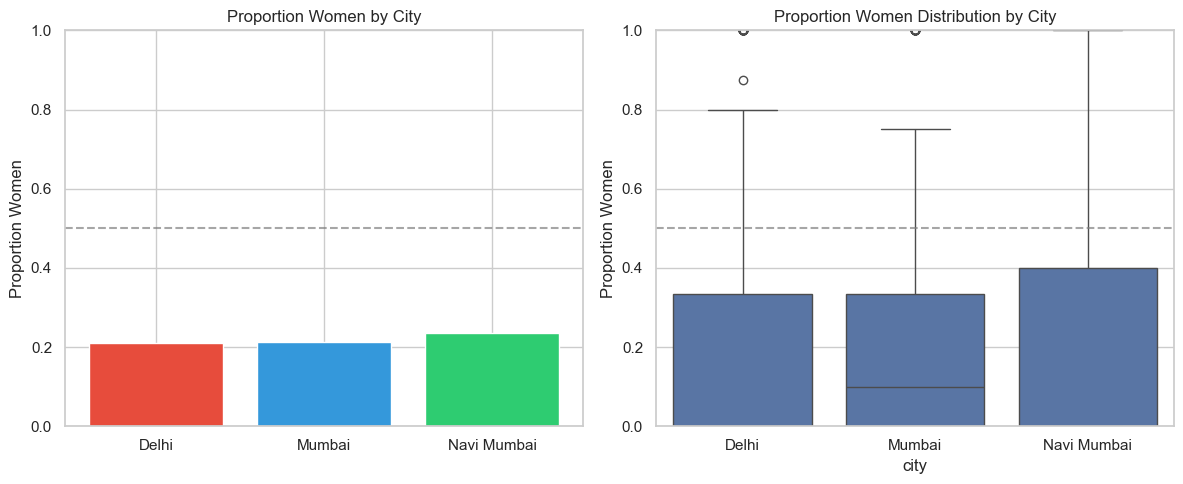

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

city_order = ["Delhi", "Mumbai", "Navi Mumbai"]
plot_df = df[df["city"].isin(city_order)].copy()

ax1 = axes[0]
city_means = plot_df.groupby("city")["prop_women"].mean().reindex(city_order)
ax1.bar(city_order, city_means.values, color=["#e74c3c", "#3498db", "#2ecc71"])
ax1.set_ylabel("Proportion Women")
ax1.set_title("Proportion Women by City")
ax1.axhline(y=0.5, color="gray", linestyle="--", alpha=0.7)
ax1.set_ylim(0, 1)

ax2 = axes[1]
sns.boxplot(data=plot_df, x="city", y="prop_women", order=city_order, ax=ax2)
ax2.set_ylabel("Proportion Women")
ax2.set_title("Proportion Women Distribution by City")
ax2.axhline(y=0.5, color="gray", linestyle="--", alpha=0.7)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "sex_ratio_by_city.png", dpi=150, bbox_inches="tight")
plt.show()

In [13]:
road_stats = (
    df.groupby("osm_type")
    .agg(
        n_annotations=("annotation_id", "count"),
        women_mean=("women_count_num", "mean"),
        men_mean=("men_count_num", "mean"),
        prop_women_mean=("prop_women", "mean"),
        prop_women_median=("prop_women", "median"),
    )
    .round(3)
)
road_stats

,n_annotations,women_mean,men_mean,prop_women_mean,prop_women_median
osm_type,,,,,
primary,79,0.342,2.430,0.113,0.000
residential,1362,0.496,1.703,0.240,0.031
secondary,166,0.735,3.681,0.170,0.062
tertiary,293,0.601,2.853,0.185,0.000
unclassified,47,0.255,1.021,0.223,0.000


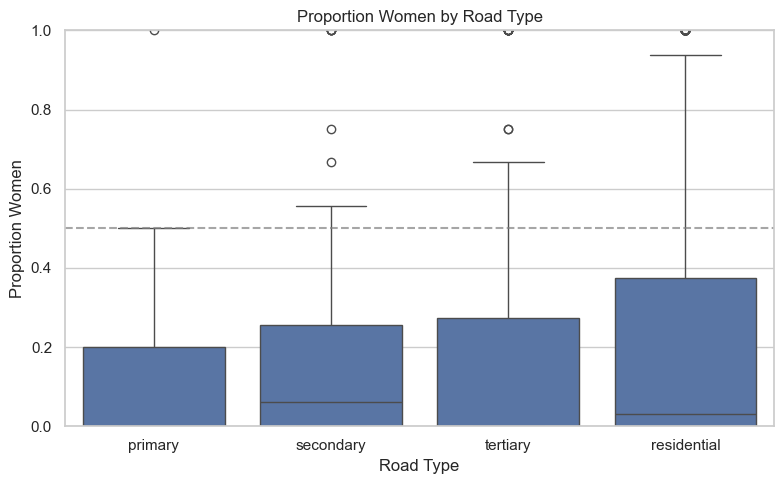

In [14]:
road_order = ["primary", "secondary", "tertiary", "residential"]
road_df = df[df["osm_type"].isin(road_order)].copy()

fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=road_df, x="osm_type", y="prop_women", order=road_order, ax=ax)
ax.set_ylabel("Proportion Women")
ax.set_xlabel("Road Type")
ax.set_title("Proportion Women by Road Type")
ax.axhline(y=0.5, color="gray", linestyle="--", alpha=0.7)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "sex_ratio_by_road_type.png", dpi=150, bbox_inches="tight")
plt.show()

In [15]:
temporal_df = df.dropna(subset=["capture_date"]).copy()

year_stats = (
    temporal_df.groupby("capture_year")
    .agg(
        n_annotations=("annotation_id", "count"),
        prop_women_mean=("prop_women", "mean"),
    )
    .round(3)
)
print("Proportion women by capture year:")
year_stats

Proportion women by capture year:


,n_annotations,prop_women_mean
capture_year,,
2015,1,NaN
2016,6,0.000
2018,1,NaN
2021,493,0.201
2022,628,0.218
2023,16,0.115
2024,401,0.239
2025,401,0.224


In [16]:
month_stats = (
    temporal_df.groupby("capture_month")
    .agg(
        n_annotations=("annotation_id", "count"),
        prop_women_mean=("prop_women", "mean"),
    )
    .round(3)
    .sort_index()
)
print("Proportion women by capture month:")
month_stats

Proportion women by capture month:


,n_annotations,prop_women_mean
capture_month,,
01,211,0.236
02,37,0.233
03,165,0.183
04,316,0.216
05,104,0.277
06,2,NaN
08,1,NaN
09,2,0.000
10,214,0.204


In [17]:
groups = [grp["prop_women"].dropna().values for _, grp in df.groupby("city") if len(grp["prop_women"].dropna()) > 0]

if len(groups) >= 2:
    stat, pvalue = stats.kruskal(*groups)
    print(f"Kruskal-Wallis test for proportion women across cities:")
    print(f"  H-statistic: {stat:.4f}")
    print(f"  p-value: {pvalue:.4e}")
else:
    print("Not enough groups for statistical test")

Kruskal-Wallis test for proportion women across cities:
  H-statistic: 4.1362
  p-value: 1.2643e-01


## Section 4: Infrastructure Analysis

In [18]:
infra_fields = ["potholes", "litter", "footpath", "lane_markings"]

for field in infra_fields:
    print(f"\n{field} value counts:")
    print(df[field].value_counts(dropna=False))


potholes value counts:
potholes
None    1847
N/A       77
Yes       19
No         4
Name: count, dtype: int64

litter value counts:
litter
None                   1411
Yes                     497
Construction debris      37
No                        2
Name: count, dtype: int64

footpath value counts:
footpath
No sidewalk        973
Paved              496
None               349
Paved - Blocked    125
Not visible          4
Name: count, dtype: int64

lane_markings value counts:
lane_markings
None    1427
Yes      443
N/A       73
No         4
Name: count, dtype: int64


In [19]:
df["has_potholes"] = df["potholes"].apply(lambda x: x == "Yes" if pd.notna(x) else False)
df["has_litter"] = df["litter"].apply(lambda x: x == "Yes" if pd.notna(x) else False)
df["has_lane_markings"] = df["lane_markings"].apply(
    lambda x: x in ["Yes", "Visible"] if pd.notna(x) else False
)

df["has_footpath"] = df["footpath"].apply(
    lambda x: x in ["Good condition", "Poor condition", "Paved", "Paved - Blocked"] if pd.notna(x) else False
)

In [20]:
infra_city = pd.DataFrame()
for field in ["has_potholes", "has_litter", "has_footpath", "has_lane_markings"]:
    rates = df.groupby("city")[field].mean() * 100
    infra_city[field.replace("has_", "")] = rates

print("Infrastructure prevalence by city (% with feature):")
infra_city.round(1)

Infrastructure prevalence by city (% with feature):


,potholes,litter,footpath,lane_markings
city,,,,
Delhi,1.3,27.1,18.6,17.3
Mumbai,0.5,21.4,50.2,29.2
Navi Mumbai,1.1,28.1,29.4,22.9


In [21]:
infra_road = pd.DataFrame()
for field in ["has_potholes", "has_litter", "has_footpath", "has_lane_markings"]:
    rates = df.groupby("osm_type")[field].mean() * 100
    infra_road[field.replace("has_", "")] = rates

print("Infrastructure prevalence by road type (% with feature):")
infra_road.reindex(road_order).round(1)

Infrastructure prevalence by road type (% with feature):


,potholes,litter,footpath,lane_markings
osm_type,,,,
primary,1.3,21.5,48.1,40.5
secondary,0.0,12.7,53.0,52.4
tertiary,1.0,24.6,49.8,33.1
residential,1.1,27.3,25.1,16.1


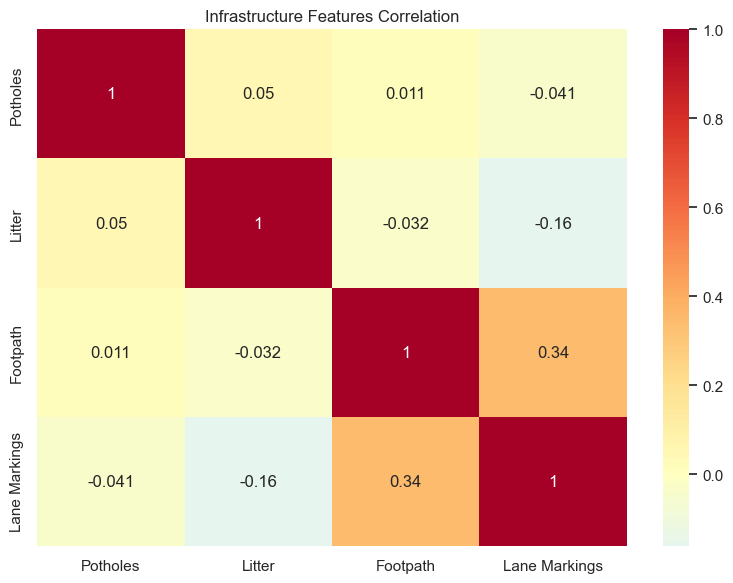

In [22]:
infra_cols = ["has_potholes", "has_litter", "has_footpath", "has_lane_markings"]
infra_corr = df[infra_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
labels = ["Potholes", "Litter", "Footpath", "Lane Markings"]
sns.heatmap(
    infra_corr,
    annot=True,
    cmap="RdYlBu_r",
    center=0,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax,
)
ax.set_title("Infrastructure Features Correlation")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "infrastructure_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

In [23]:
print("\nLand use distribution by city:")
land_use_city = pd.crosstab(df["city"], df["land_use"], normalize="index") * 100
land_use_city.round(1)


Land use distribution by city:


land_use,Commercial/Institutional,Highway/Out of city/Empty land,Mixed use,Residential
city,,,,
Delhi,24.7,6.1,33.0,36.2
Mumbai,24.8,1.7,41.0,32.4
Navi Mumbai,25.8,0.0,37.9,36.3


In [24]:
print("\nLand use distribution by road type:")
land_use_road = pd.crosstab(df["osm_type"], df["land_use"], normalize="index") * 100
land_use_road.reindex(road_order).round(1)


Land use distribution by road type:


land_use,Commercial/Institutional,Highway/Out of city/Empty land,Mixed use,Residential
osm_type,,,,
primary,57.3,1.3,37.3,4.0
secondary,50.0,6.9,35.6,7.5
tertiary,42.9,4.0,37.5,15.6
residential,15.6,2.3,37.1,45.0


In [25]:
summary = df.groupby("city").agg(
    n_annotations=("annotation_id", "count"),
    n_locations=("location_id", "nunique"),
    women_mean=("women_count_num", "mean"),
    women_std=("women_count_num", "std"),
    men_mean=("men_count_num", "mean"),
    men_std=("men_count_num", "std"),
    prop_women_mean=("prop_women", "mean"),
    prop_women_std=("prop_women", "std"),
    pct_with_footpath=("has_footpath", "mean"),
    pct_with_litter=("has_litter", "mean"),
    pct_with_potholes=("has_potholes", "mean"),
    pct_with_lane_markings=("has_lane_markings", "mean"),
).round(3)

summary.to_csv(OUTPUT_DIR / "city_summary.csv")
print(f"Saved city summary to {OUTPUT_DIR / 'city_summary.csv'}")
summary

Saved city summary to ../data/analysis/city_summary.csv


,n_annotations,n_locations,women_mean,women_std,men_mean,men_std,prop_women_mean,prop_women_std,pct_with_footpath,pct_with_litter,pct_with_potholes,pct_with_lane_markings
city,,,,,,,,,,,,
Delhi,774,500,0.377,0.917,1.579,2.779,0.209,0.321,0.186,0.271,0.013,0.173
Mumbai,636,498,0.731,1.274,3.121,4.151,0.213,0.286,0.502,0.214,0.005,0.292
Navi Mumbai,537,437,0.475,1.270,1.488,2.702,0.235,0.314,0.294,0.281,0.011,0.229


In [26]:
road_summary = df.groupby("osm_type").agg(
    n_annotations=("annotation_id", "count"),
    n_locations=("location_id", "nunique"),
    women_mean=("women_count_num", "mean"),
    men_mean=("men_count_num", "mean"),
    prop_women_mean=("prop_women", "mean"),
    pct_with_footpath=("has_footpath", "mean"),
    pct_with_litter=("has_litter", "mean"),
    pct_with_potholes=("has_potholes", "mean"),
    pct_with_lane_markings=("has_lane_markings", "mean"),
).round(3)

road_summary.to_csv(OUTPUT_DIR / "road_type_summary.csv")
print(f"Saved road type summary to {OUTPUT_DIR / 'road_type_summary.csv'}")
road_summary

Saved road type summary to ../data/analysis/road_type_summary.csv


,n_annotations,n_locations,women_mean,men_mean,prop_women_mean,pct_with_footpath,pct_with_litter,pct_with_potholes,pct_with_lane_markings
osm_type,,,,,,,,,
primary,79,63,0.342,2.430,0.113,0.481,0.215,0.013,0.405
residential,1362,1003,0.496,1.703,0.240,0.251,0.273,0.011,0.161
secondary,166,120,0.735,3.681,0.170,0.530,0.127,0.000,0.524
tertiary,293,215,0.601,2.853,0.185,0.498,0.246,0.010,0.331
unclassified,47,34,0.255,1.021,0.223,0.149,0.319,0.000,0.170


In [27]:
print("\n=== Analysis Complete ===")
print(f"\nTotal annotations analyzed: {len(df)}")
print(f"Unique locations: {df['location_id'].nunique()}")
print(f"\nOutput files saved to: {OUTPUT_DIR.resolve()}")
for f in OUTPUT_DIR.glob("*"):
    print(f"  - {f.name}")


=== Analysis Complete ===

Total annotations analyzed: 1947
Unique locations: 1435

Output files saved to: /Users/soodoku/Documents/GitHub/missing_women_gsview/data/analysis
  - annotated_locations_map.html
  - combined_annotations.csv
  - road_type_summary.csv
  - sex_ratio_heatmap.html
  - infrastructure_correlation.png
  - sex_ratio_by_road_type.png
  - city_summary.csv
  - sex_ratio_by_city.png
